# Problema

Agora você tem que criar um Data App utilizando Streamlit para explorar os dados anteriores. Para criar um Data App, acesse nosso módulo de inteligência e siga este guia na nossa documentação.

## Impeditivo:

Não consegui logar no Módulo de Inteligência na Dadosfera, o botão de login simplesmente parece não funcionar. Por isso, vou fazer o App no Streamlit manualmente. A ideia é fazer um embedding das palavras mais comuns utilizadas no título e descrição dos produtos e visualizar esse resultado com um t-SNE, um método de redução de dimensionalidade (parecido com UMAP). 

Esse notebook foi feito exatemente para testes desse embedding, e foi desenvolvido com base no [notebook](https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook) do Kaggle do usuário Jeff Delaney (inclusive o código foi adaptado desse notebook).

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from gensim.models import word2vec
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir("..")

In [3]:
df = (pd.read_parquet("artifacts/data_transformation/df_categories_v2.parquet")
      .sample(frac=0.1, random_state=42))

Adicionando mais stopwords:

In [4]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
extra_stopwords = ["✓", "-", "&", "x", "page", "/", "Set", " ", "diy",
                   "ft", "end", "cm", "due", "mm", "yes", "no"]
numeros_strings = [str(i) for i in range(1, 100001)]
alfabeto = [chr(i) for i in range(ord('a'), ord('z')+1)]

stop_words.extend(extra_stopwords)
stop_words.extend(numeros_strings)
stop_words.extend(alfabeto)

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Limpando os dados para o NLP:

In [5]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in stop_words:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['title', 'text']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

In [6]:
df2 = clean_dataframe(df)

Construção do corpus:

In [ ]:
def build_corpus(df):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['title', 'text']:
        for index, sentence in df.iterrows():
            if pd.notna(sentence[col]):  # Check for NaN values in the column
                word_list = sentence[col].split(" ")
                corpus.append(word_list)
            
    return corpus

In [ ]:
corpus = build_corpus(df2)        

In [ ]:
# import nltk
# from collections import Counter

# # Certifique-se de ter o NLTK baixado e configurado
# nltk.download('punkt')


# # Combine todas as listas de palavras em um único grande texto
# texto = [palavra for lista in corpus for palavra in lista]

# # Realize a contagem das palavras
# contagem_palavras = Counter(texto)

# # Obtenha as 100 palavras mais comuns
# palavras_mais_comuns = contagem_palavras.most_common(100)

[nltk_data] Downloading package punkt to /home/bruno/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Aplicação do modelo:

In [ ]:
n_threads = len(os.sched_getaffinity(0))
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=15000, workers=n_threads)

Visualização:

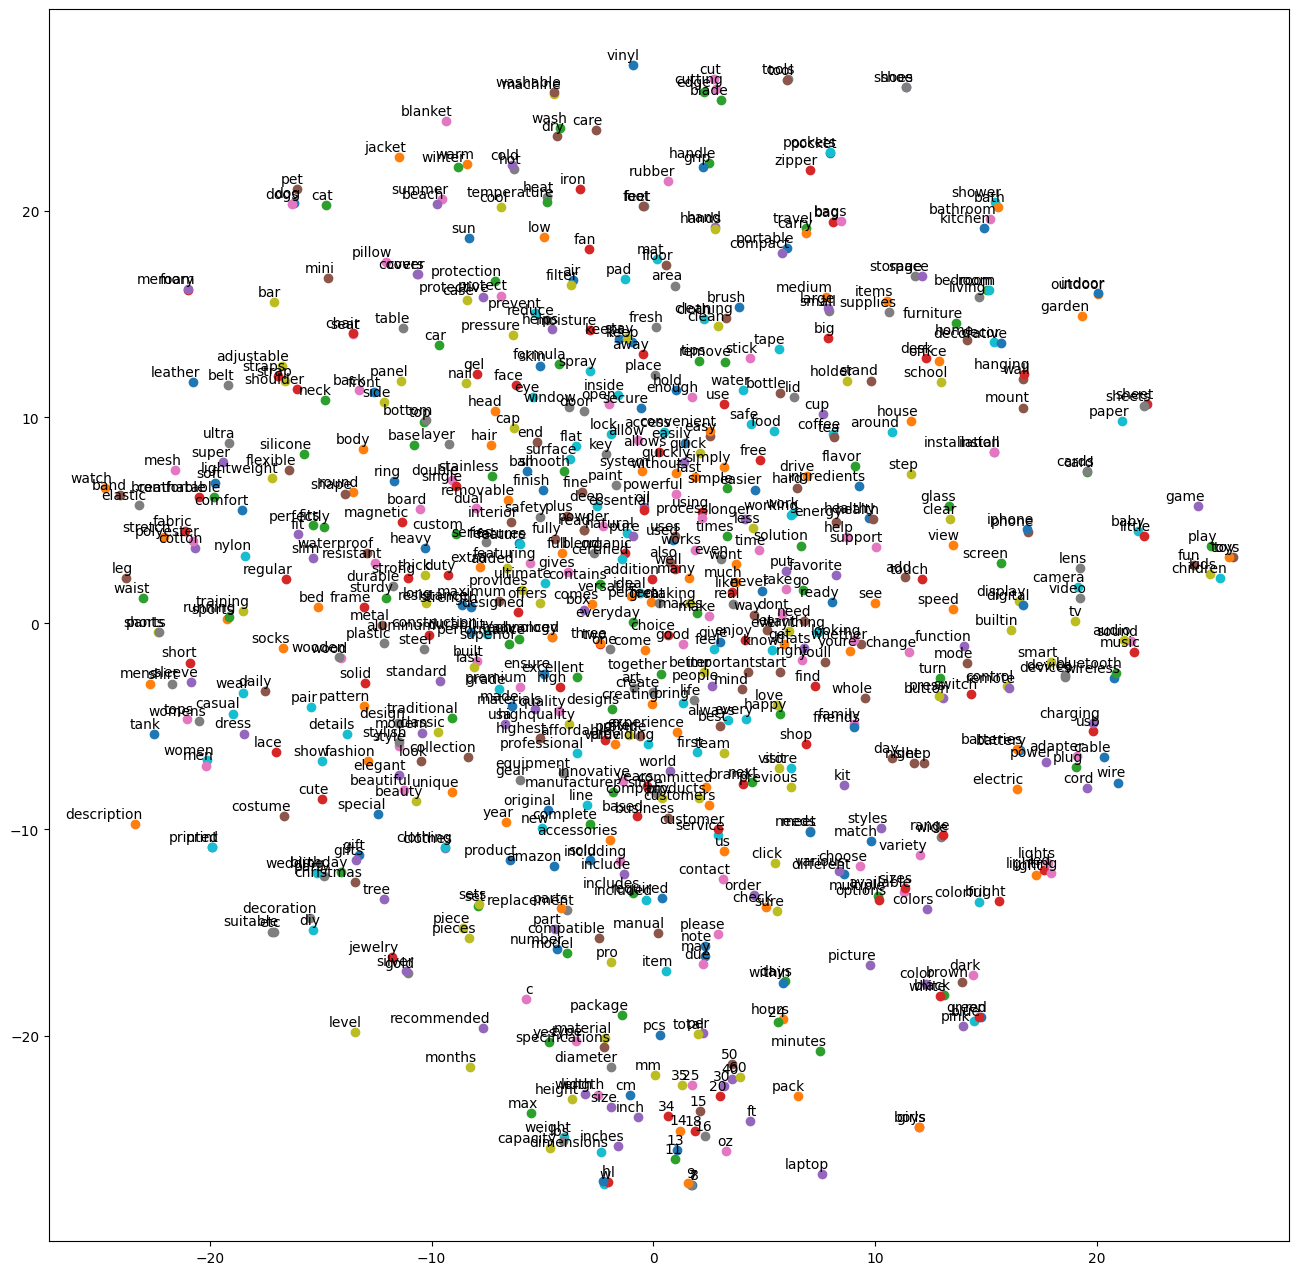

In [ ]:
def tsne_plot(model):
    "Cria um modelo TSNE e o plota"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    # Converter a lista tokens em uma matriz NumPy
    tokens = np.array(tokens)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)

In [14]:

model.save("models/word_embedding2.kvmodel")

In [15]:
from gensim.models import KeyedVectors
kv2 = KeyedVectors.load("models/word_embedding2.kvmodel")

In [16]:
def tsne_plot(model):
    "Cria um modelo TSNE e o plota"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    # Converter a lista tokens em uma matriz NumPy
    tokens = np.array(tokens)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(kv2)